In [1]:
import pandas as pd
import chart_studio
chart_studio.tools.set_credentials_file(username='username', api_key='api_key')
import chart_studio.plotly as py
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import *

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # For creating plots
import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt


In [2]:
#파일 불러오기
file_path = '../Churn.xlsx'
data = pd.read_excel(file_path)

In [128]:
#data['Membership'] = data['Membership'].map({'None': 0, 'Offer A': 1, 'Offer B': 2, 'Offer C': 3, 'Offer D': 4, 'Offer E': 5})
#data['Churn Value'] = data['Churn Value'].map({0: 'No', 1: 'Yes'})


In [3]:
data.head()

,Age,Age Group,Number of Dependents,Membership,Satisfaction Score,Tech services,Streaming services,Combined Product,Contract,Tenure in Months,Monthly Charge,Total Revenue,Churn Value
0,78,70,0,None,3,1,1,2,Month-to-Month,1,39.65,59.65,1
1,74,70,1,Offer E,3,1,0,4,Month-to-Month,8,80.65,1024.10,1
2,71,70,3,Offer D,2,0,2,4,Month-to-Month,18,95.45,1910.88,1
3,78,70,1,Offer C,2,2,2,4,Month-to-Month,25,98.50,2995.07,1
4,80,80,1,Offer C,2,0,0,4,Month-to-Month,37,76.50,3102.36,1


In [4]:
#더미 변수화
d_data = pd.get_dummies(data)
d_data.head()

,Age,Age Group,Number of Dependents,Satisfaction Score,Tech services,Streaming services,Combined Product,Tenure in Months,Monthly Charge,Total Revenue,Churn Value,Membership_None,Membership_Offer A,Membership_Offer B,Membership_Offer C,Membership_Offer D,Membership_Offer E,Contract_Month-to-Month,Contract_One Year,Contract_Two Year
0,78,70,0,3,1,1,2,1,39.65,59.65,1,1,0,0,0,0,0,1,0,0
1,74,70,1,3,1,0,4,8,80.65,1024.10,1,0,0,0,0,0,1,1,0,0
2,71,70,3,2,0,2,4,18,95.45,1910.88,1,0,0,0,0,1,0,1,0,0
3,78,70,1,2,2,2,4,25,98.50,2995.07,1,0,0,0,1,0,0,1,0,0
4,80,80,1,2,0,0,4,37,76.50,3102.36,1,0,0,0,1,0,0,1,0,0


<AxesSubplot:>

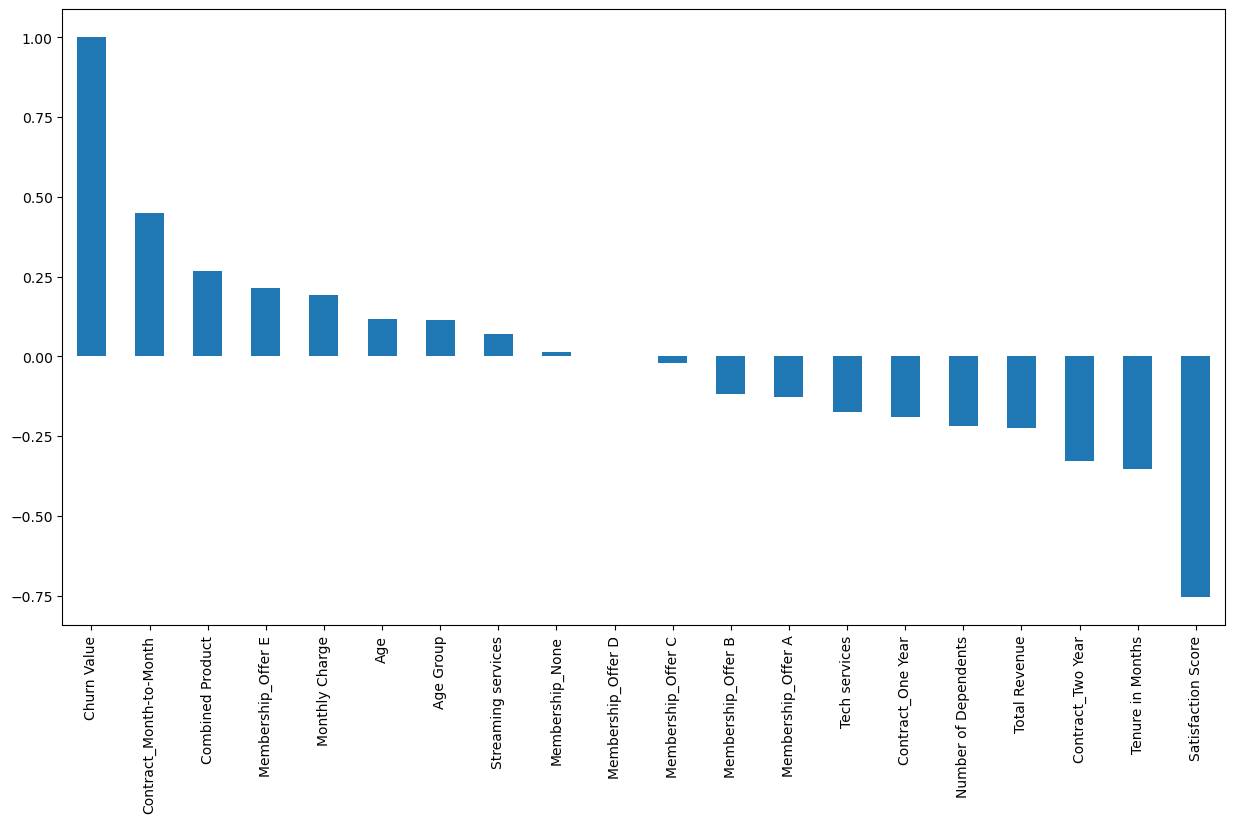

In [5]:
# Churn Value와 다른 열들 간의 상관 관계 계산 및 시각화
plt.figure(figsize=(15,8))
d_data.corr()['Churn Value'].sort_values(ascending = False).plot(kind='bar')

In [6]:
from sklearn.preprocessing import StandardScaler

# Churn Value 열을 타겟 변수로 설정. 종속 변수와 독립 변수 분리
y = d_data['Churn Value'].values
X = d_data.drop(columns=['Churn Value'])

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

# Standard 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE 오버샘플링
over = SMOTE(sampling_strategy='auto', random_state=88)
X_train_resampled, y_train_resampled = over.fit_resample(X_train_scaled, y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_resampled.shape, y_train_resampled.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_resampled).value_counts())


SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (4930, 19) (4930,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (7220, 19) (7220,)
SMOTE 적용 후 레이블 값 분포: 
 0    3610
1    3610
dtype: int64


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 로지스틱 회귀 모델 튜닝
lr_model = LogisticRegression()

# 하이퍼파라미터 그리드 설정
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# GridSearchCV를 사용한 하이퍼파라미터 튜닝
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

# 최적 하이퍼파라미터 출력
print("로지스틱 회귀 모델 최적 하이퍼파라미터:", grid_search.best_params_)

# 최적 모델로 재학습
best_lr_model = grid_search.best_estimator_
best_lr_model.fit(X_train_resampled, y_train_resampled)

# 테스트 데이터로 성능 평가
y_pred_lr = best_lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
confusion_lr = confusion_matrix(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)

print("로지스틱 회귀 모델 정확도:", accuracy_lr)
print("로지스틱 회귀 모델 혼동 행렬:\n", confusion_lr)
print("로지스틱 회귀 모델 분류 보고서:\n", report_lr)

로지스틱 회귀 모델 최적 하이퍼파라미터: {'C': 100, 'penalty': 'l2'}
로지스틱 회귀 모델 정확도: 0.8206341694273545
로지스틱 회귀 모델 혼동 행렬:
 [[1312  252]
 [ 127  422]]
로지스틱 회귀 모델 분류 보고서:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87      1564
           1       0.63      0.77      0.69       549

    accuracy                           0.82      2113
   macro avg       0.77      0.80      0.78      2113
weighted avg       0.84      0.82      0.83      2113



D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Valu

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


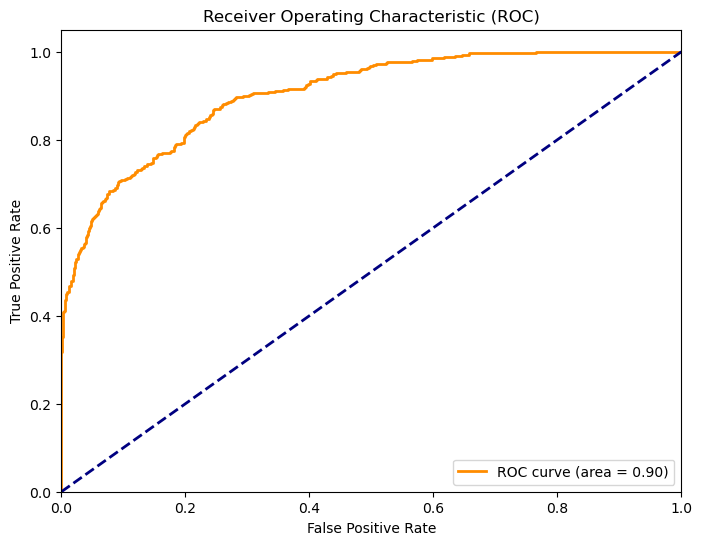

In [8]:
# ROC 곡선 그리기
y_score_lr = best_lr_model.decision_function(X_test)  # 로지스틱 회귀의 결정 함수 값
fpr, tpr, _ = roc_curve(y_test, y_score_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

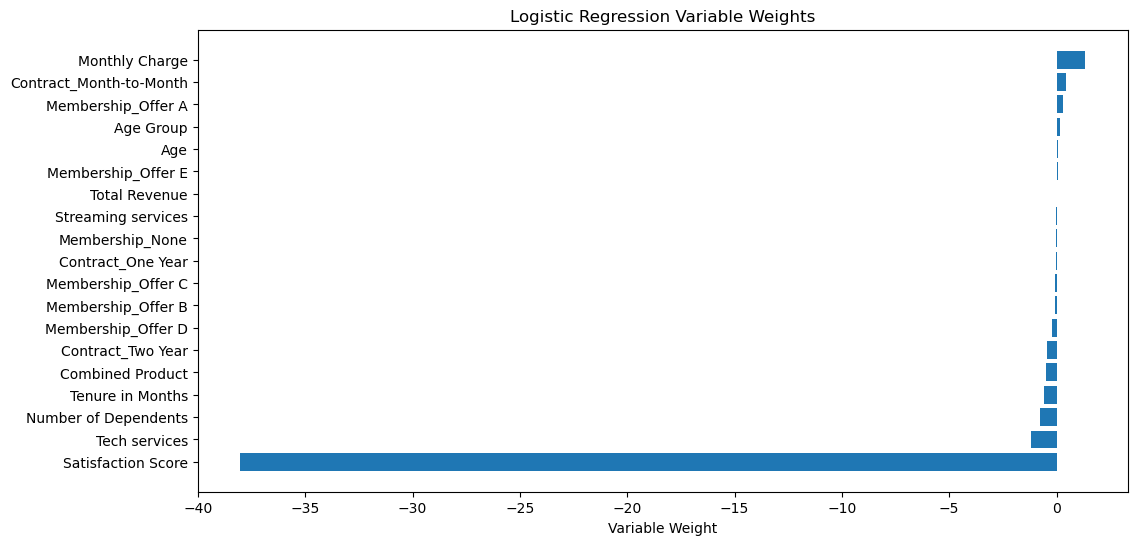

In [10]:

# 로지스틱 회귀 모델의 변수 가중치 추출
weights = best_lr_model.coef_[0]

# 변수 이름을 인덱스와 함께 저장
feature_names = list(X.columns)
weight_dict = dict(zip(feature_names, weights))

# 변수 가중치를 기준으로 내림차순 정렬
sorted_weights = sorted(weight_dict.items(), key=lambda x: x[1], reverse=True)

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_weights)), [item[1] for item in sorted_weights], align='center')
plt.yticks(range(len(sorted_weights)), [item[0] for item in sorted_weights])
plt.xlabel('Variable Weight')
plt.title('Logistic Regression Variable Weights')
plt.gca().invert_yaxis()  # 상위 변수가 위로 올라오도록 뒤집기
plt.show()